In [1]:
from fastai.collab import *
from fastai.tabular.all import *
import os
import urllib.request
import zipfile
set_seed(42)

In [2]:
input_dir = "/kaggle/input/"
dataset_dirs = os.listdir(input_dir)
ratings_path = ""

for directory in dataset_dirs:
    if os.path.exists(os.path.join(input_dir, directory, "ratings.csv")):
        ratings_path = os.path.join(input_dir, directory, "ratings.csv")
        break
    else:
        for inner_directory in os.listdir(os.path.join(input_dir, directory)):
            if os.path.exists(os.path.join(input_dir, directory, inner_directory, "ratings.csv")):
                ratings_path = os.path.join(input_dir, directory, inner_directory, "ratings.csv")
                break
        if ratings_path != "":
            break

In [3]:
ratings = pd.read_csv(ratings_path)
ratings.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [4]:
movies_path = ""

for directory in dataset_dirs:
    if os.path.exists(os.path.join(input_dir, directory, "movies.csv")):
        movies_path = os.path.join(input_dir, directory, "movies.csv")
        break
    else:
        for inner_directory in os.listdir(os.path.join(input_dir, directory)):
            if os.path.exists(os.path.join(input_dir, directory, inner_directory, "movies.csv")):
                movies_path = os.path.join(input_dir, directory, inner_directory, "movies.csv")
                break
        if movies_path != "":
            break

movies = pd.read_csv(movies_path)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings = ratings.merge(movies)
ratings.head()

,userId,movieId,rating,timestamp,title,genres
0,1,17,4.0,944249077,Sense and Sensibility (1995),Drama|Romance
1,1,25,1.0,944250228,Leaving Las Vegas (1995),Drama|Romance
2,1,29,2.0,943230976,"City of Lost Children, The (Cité des enfants perdus, La) (1995)",Adventure|Drama|Fantasy|Mystery|Sci-Fi
3,1,30,5.0,944249077,Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Crime|Drama
4,1,32,5.0,943228858,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller


In [6]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,userId,title,rating
0,29561,"Call, The (2013)",4.0
1,155123,Never Been Kissed (1999),4.0
2,174589,Zoolander (2001),2.5
3,128093,Gran Torino (2008),4.0
4,86858,"Bourne Ultimatum, The (2007)",4.0
5,115610,Indiana Jones and the Temple of Doom (1984),3.0
6,9686,Under Siege 2: Dark Territory (1995),4.0
7,18729,Angels & Demons (2009),3.0
8,12045,"Faculty, The (1998)",3.0
9,48081,"Mist, The (2007)",3.0


In [7]:
n_users = len(dls.classes['userId'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [8]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [9]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.022788,1.016500,52:09
1,1.024719,1.017089,52:15
2,1.001856,0.989912,52:06
3,0.938638,0.944518,52:01
4,0.918867,0.910877,52:10


In [10]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(200949, 50)
  (i_weight): Embedding(84240, 50)
  (u_bias): Embedding(200949, 1)
  (i_bias): Embedding(84240, 1)
)

In [11]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=False)[:5]
[dls.classes['title'][i] for i in idxs]

['Battlefield Earth (2000)',
 'Speed 2: Cruise Control (1997)',
 'Batman & Robin (1997)',
 'Anaconda (1997)',
 'Super Mario Bros. (1993)']

In [12]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Footloose (1984)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Kiss of the Dragon (2001)'

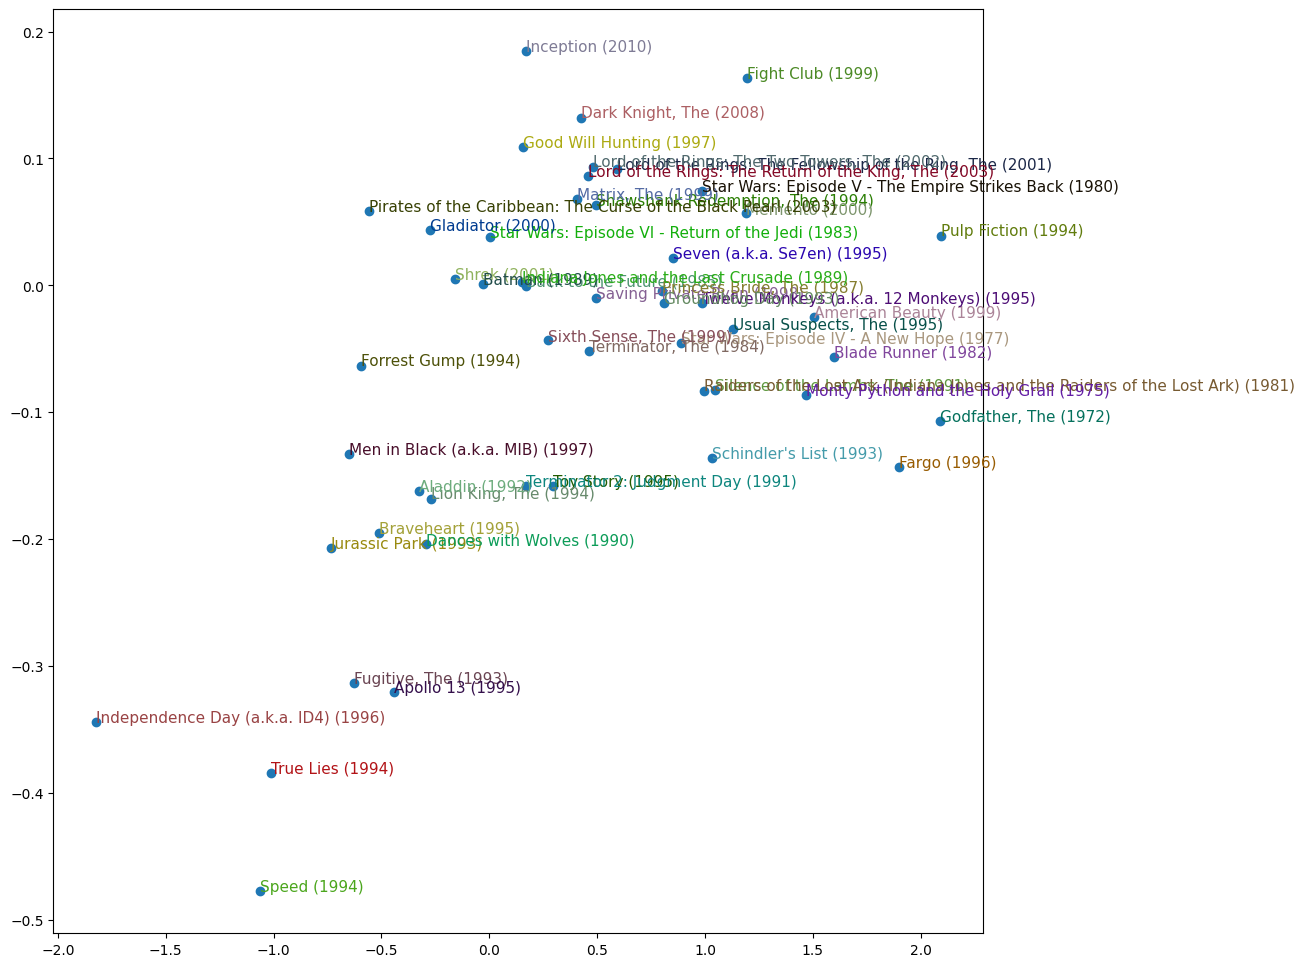

In [13]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()